# MALIGNANT COMMENTS CLASSIFICATION

##  Problem Statement

The proliferation of social media enables people to express their opinions widely online. However, at the same time, this has resulted in the emergence of conflict and hate, making online environments uninviting for users. Although researchers have found that hate is a problem across multiple platforms, there is a lack of models for online hate detection.

Online hate, described as abusive language, aggression, cyberbullying, hatefulness and many others has been identified as a major threat on online social media platforms. Social media platforms are the most prominent grounds for such toxic behaviour.

There has been a remarkable increase in the cases of cyberbullying and trolls on various social media platforms. Many celebrities and influences are facing backlashes from people and have to come across hateful and offensive comments. This can take a toll on anyone and affect them mentally leading to depression, mental illness, self-hatred and suicidal thoughts.

Internet comments are bastions of hatred and vitriol. While online anonymity has provided a new outlet for aggression and hate speech, machine learning can be used to fight it. The problem we sought to solve was the tagging of internet comments that are aggressive towards other users. This means that insults to third parties such as celebrities will be tagged as unoffensive, but “u are an idiot” is clearly offensive.

Our goal is to build a prototype of online hate and abuse comment classifier which can used to classify hate and offensive comments so that it can be controlled and restricted from spreading hatred and cyberbullying.

###### downloading important packages

In [2]:
pip install scikit-plot


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-multilearn

Note: you may need to restart the kernel to use updated packages.


In [3]:
# importing necessary libraries
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import missingno
import pandas_profiling
from scipy import interp
import scikitplot as skplt
from itertools import cycle
import matplotlib.ticker as plticker

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, regexp_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.sparse import csr_matrix

import timeit, sys
from sklearn import metrics
import tqdm.notebook as tqdm
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import hamming_loss, log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, multilabel_confusion_matrix
from scikitplot.metrics import plot_roc_curve

In [4]:
import os

In [5]:
#importing train dataset
os.chdir("C:\GitBash\Files\Malignant Comments Classifier Project")
df_train = pd.read_csv("train.csv")

In [6]:
df_train

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In our training dataset we see that the dataframe has a total of 1,59,571 rows and 8 columns. We don't see any importance of the id column however the comment column helps us label through the remaining columns in binary labels.

In [7]:
#importing test dataset
os.chdir("C:\GitBash\Files\Malignant Comments Classifier Project")
df_test = pd.read_csv("test.csv")
df_test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In our testing dataset we see that there are 1,53,164 rows and only 2 columns present in this dataframe. This gives us the idea that we will need to create additional columns to mark the comments into various categories as per our model confidence. Once again the id column does not seem to offer any significance and can be removed.

## EXPLANATORY DATA ANALYSIS

#### Performing EDA on training dataset

In [8]:
print("We have {} Rows and {} Columns in our dataframe".format(df_train.shape[0], df_train.shape[1]))
df_train.head(20)

We have 159571 Rows and 8 Columns in our dataframe


,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


We can see that our training dataframe consists of 159571 rows and 8 columns in total.

Column Description:

id : A unique id aligned with each comment text.

comment_text : It includes the comment text.

malignant : It is a column with binary values depicting which comments are malignant in nature.

highly_malignant : Binary column with labels for highly malignant text.

rude : Binary column with labels for comments that are rude in nature.

threat : Binary column with labels for threatening context in the comments.

abuse : Binary column with labels with abusive behaviour.

loathe : Label to comments that are full of loathe and hatred.

In [9]:
#Checking for missing values
df_train.isna().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

We can see that none of the columns from training datase have missing values

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


We see here that we have a total of 8 columns out of which 2 columns have object datatype while the remaining 6 columns are of integer datatype.

In [11]:
# checking ratio of data which contains malignant comments and normal or unoffensive comments.
output_labels = df_train.columns[2:]

# counting non-zero rows i.e. Malignant Comments
malignant_comments = len(df_train[df_train[output_labels].any(axis=1)])

# counting rows containing zero i.e. Normal Comments
normal_comments = len(df_train)-malignant_comments

print(f"Total Malignant Comments: {malignant_comments} ({round(malignant_comments*100/len(df_train),2)}%)")
print(f"Total Normal Comments: {normal_comments} ({round(normal_comments*100/len(df_train),2)}%)")


Total Malignant Comments: 16225 (10.17%)
Total Normal Comments: 143346 (89.83%)



Above ratio shows that our dataframe consists 10.17% of Malignant Comments and 89.83% of Normal Comments. Hence, it is clear that the dataset is imbalanced and needs to be treated accordingly during train test split of model training.

In [12]:
# checking the length of comments and storing it into another column 'original_length'
# copying df_train into another object df
df = df_train.copy()
df['original_length'] = df.comment_text.str.len()

In [13]:
# checking the first five and last five rows here
df

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,original_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,295
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,99
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,81
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,116


### DATA CLEANING

In [14]:
# as the feature 'id' has no relevance w.r.t. model training lets drop this column
df.drop(columns=['id'],inplace=True)
# converting comment text to lowercase format
df['comment_text'] = df.comment_text.str.lower()
df.head()


,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,original_length
0,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0,264
1,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0,112
2,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0,233
3,"""\nmore\ni can't make any real suggestions on ...",0,0,0,0,0,0,622
4,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0,67


We have converted all the text data in our comment text column into lowercase format for easier interpretation

In [15]:
# Removing and Replacing unwanted characters in the comment_text column

# Replacing '\n' with ' '
df.comment_text = df.comment_text.str.replace('\n',' ')

# Keeping only text with letters a to z, 0 to 9 and words like can't, don't, couldn't etc
df.comment_text = df.comment_text.apply(lambda x: ' '.join(regexp_tokenize(x,"[a-z']+")))

# Removing Stop Words and Punctuations

# Getting the list of stop words of english language as set
stop_words = set(stopwords.words('english'))

# Updating the stop_words set by adding letters from a to z
for ch in range(ord('a'),ord('z')+1):
    stop_words.update(chr(ch))
    
# Updating stop_words further by adding some custom words
custom_words = ("d'aww","mr","hmm","umm","also","maybe","that's","he's","she's","i'll","he'll","she'll","us",
                "ok","there's","hey","heh","hi","oh","bbq","i'm","i've","nt","can't","could","ur","re","ve",
                "rofl","lol","stfu","lmk","ily","yolo","smh","lmfao","nvm","ikr","ofc","omg","ilu")
stop_words.update(custom_words)

# Checking the new list of stop words
print("New list of custom stop words are as follows:\n\n")
print(stop_words)

New list of custom stop words are as follows:


{'has', 'having', 'o', 'here', 'myself', 'very', "mustn't", 'his', 'have', 'after', 'ourselves', 've', 'omg', 'hers', 'their', 'so', 'ma', 'maybe', 'ur', 'ikr', 'to', 'while', 'why', 'too', 'more', 'who', 'through', 'what', 'lmfao', 'ilu', "wasn't", 'j', 'over', 'now', 'e', 'yourselves', 'aren', 'theirs', 'needn', 'my', "she's", 's', 'being', 'off', 'hey', 'again', 'will', "that's", 'an', 'nor', 'can', 'such', 'k', 'during', "i'll", 'bbq', 'just', 'in', 'hmm', 'on', 'p', 'was', 'l', 'are', 'oh', 'the', 'g', 'x', 'up', "hasn't", 'only', 'heh', 'yolo', 'be', 'r', 'him', "i'm", 'doesn', 'these', 'all', 'll', 'couldn', 'itself', 'mightn', 'further', 'most', 'shouldn', 'nvm', 'this', 'those', "you've", 'mr', 'at', 'yours', 'before', "you'd", 'she', 'when', 'isn', 'is', 'ours', "aren't", 'own', 'there', 'her', 'against', 'by', 'should', 'ain', "didn't", 'hasn', 'q', 'z', 'does', 'were', 'could', 'do', "wouldn't", 'of', 'wasn', "he's", 'or', 'ab

In [16]:
# Removing stop words
df.comment_text = df.comment_text.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words).strip())

# Removing punctuations
df.comment_text = df.comment_text.str.replace("[^\w\d\s]","")

# Checking any 10 random rows to see the applied changes
df.sample(10)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,original_length
7477,trade wizards nba draft night bulls traded kir...,0,0,0,0,0,0,255
133829,week far cameron alone opinion link gb inappro...,0,0,0,0,0,0,203
40718,come founder british foreign bible society fou...,0,0,0,0,0,0,115
115754,hate armenia dumb allies deserve live wait til...,1,0,1,1,1,1,111
95935,qamishlo historically kurds syriac armenian sy...,0,0,0,0,0,0,699
58591,applicable owen toon added substantial content...,0,0,0,0,0,0,109
23343,sweet home talk,0,0,0,0,0,0,41
41093,hope succeeded successfully uploading images c...,0,0,0,0,0,0,94
40434,true ark hold copyrights songs produce release...,0,0,0,0,0,0,498
58015,read sure looking thanks read,0,0,0,0,0,0,63


In [18]:
# Stemming words
snb_stem = SnowballStemmer('english')
df.comment_text = df.comment_text.apply(lambda x: ' '.join(snb_stem.stem(word) for word in word_tokenize(x)))

# Checking any 10 random rows to see the applied changes
df.sample(10)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,original_length
132225,disrespect user creat page mean think would be...,0,0,0,0,0,0,248
128588,respond post kingdom exist novemb df yugoslavi...,0,0,0,0,0,0,495
99242,usag term sometim use within israel predomin f...,0,0,0,0,0,0,3460
43679,mistak srri,0,0,0,0,0,0,20
87583,write writer vessel song written twenti one pi...,0,0,0,0,0,0,182
101827,respons ask look section remov redund factual ...,0,0,0,0,0,0,164
118020,thank understood remov molevol comment talk pa...,0,0,0,0,0,0,228
67376,daniel rigal feel free suck ball,1,0,1,0,0,0,42
78715,huaorani languag sabela languag see recent mad...,0,0,0,0,0,0,315
154617,februari fact produc importscript user dr pda ...,0,0,0,0,0,0,97


In [19]:
# Checking the length of comment_text after cleaning and storing it in cleaned_length variable
df["cleaned_length"] = df.comment_text.str.len()

# Taking a loot at first 10 rows of data
df.head(10)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,original_length,cleaned_length
0,explan edit made usernam hardcor metallica fan...,0,0,0,0,0,0,264,135
1,match background colour seem stuck thank talk ...,0,0,0,0,0,0,112,57
2,man realli tri edit war guy constant remov rel...,0,0,0,0,0,0,233,112
3,make real suggest improv wonder section statis...,0,0,0,0,0,0,622,310
4,sir hero chanc rememb page,0,0,0,0,0,0,67,26
5,congratul well use tool well talk,0,0,0,0,0,0,65,33
6,cocksuck piss around work,1,1,1,0,1,0,44,25
7,vandal matt shirvington articl revert pleas ban,0,0,0,0,0,0,115,47
8,sorri word nonsens offens anyway intend write ...,0,0,0,0,0,0,472,235
9,align subject contrari dulithgow,0,0,0,0,0,0,70,32


In [21]:
#now checking the percentage of length cleaned
print(f"Total Original Length        : {df.original_length.sum()}")
print(f"Total Cleaned Length         : {df.cleaned_length.sum()}")
print(f"Percentage of Length Cleaned : {(df.original_length.sum()-df.cleaned_length.sum())*100/df.original_length.sum()}%")


Total Original Length        : 62893130
Total Cleaned Length         : 34297506
Percentage of Length Cleaned : 45.46700728680541%


## VISUALIZATION

In [24]:
#using pandas-profiling to generate interactive reports in web format that can be presented for project report. 

In [22]:
pandas_profiling.ProfileReport(df)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

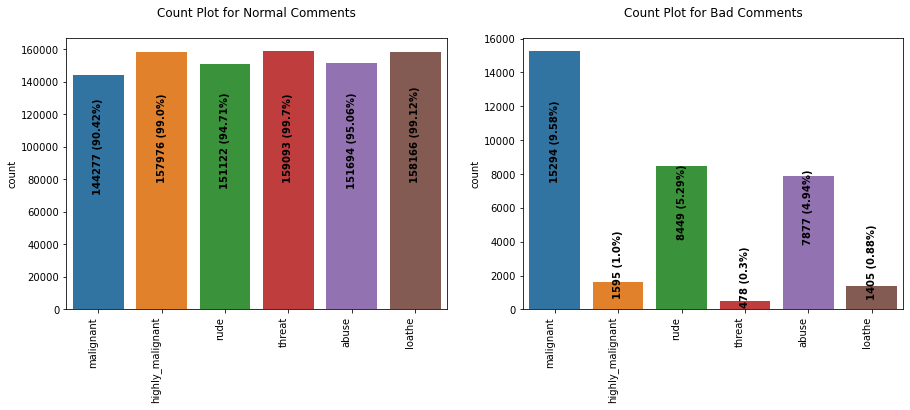

In [23]:
# comparing normal comments and bad comments using count plot

fig, ax = plt.subplots(1,2,figsize=(15,5))

for i in range(2):
    sns.countplot(data=df[output_labels][df[output_labels]==i], ax=ax[i])
    if i == 0:
        ax[i].set_title("Count Plot for Normal Comments\n")
    else:
        ax[i].set_title("Count Plot for Bad Comments\n")
        
    ax[i].set_xticklabels(output_labels, rotation=90, ha="right")
    p=0
    for prop in ax[i].patches:
        count = prop.get_height()
        s = f"{count} ({round(count*100/len(df),2)}%)"
        ax[i].text(p,count/2,s,rotation=90, ha="center", fontweight="bold")
        p += 1

plt.show()

Dataset consists of higher number of Normal Comments than Bad or Malignant Comments. Therefore, it is clear that dataset is imbalanced and needs to be handle accordingly.

Most of the bad comments are of type malignant while least number of type threat is present in dataset.

Majority of bad comments are of type malignant, rude and abuse.

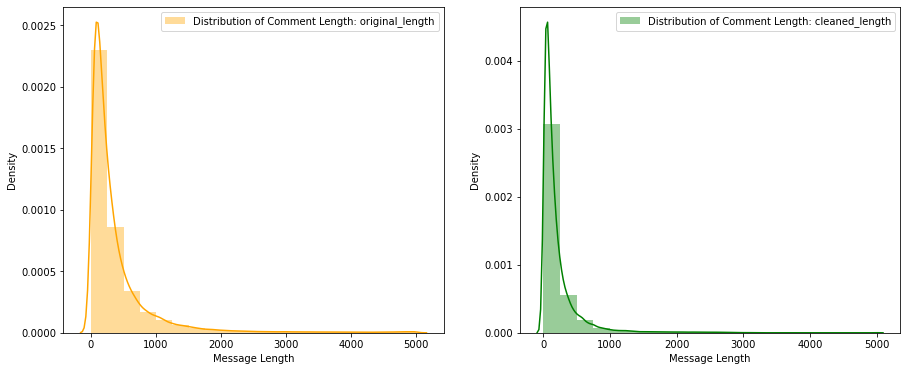

In [25]:
# Comparing the comment text length distribution before cleaning and after cleaning

fig, ax = plt.subplots(1,2,figsize=(15,6))
j=0
colors = ['orange','green']
for i in df.columns[-2:]:
    label_text = f"Distribution of Comment Length: {i}"
    sns.distplot(df[i],ax=ax[j],bins=20,color=colors[j],label=label_text)
    ax[j].set_xlabel("Message Length")
    ax[j].legend()
    j += 1
    
plt.show()

It is observed that before cleaning comment_text column most of the comment's length lies between 0 to 1100 while after cleaning it has been reduced between 0 to 900.

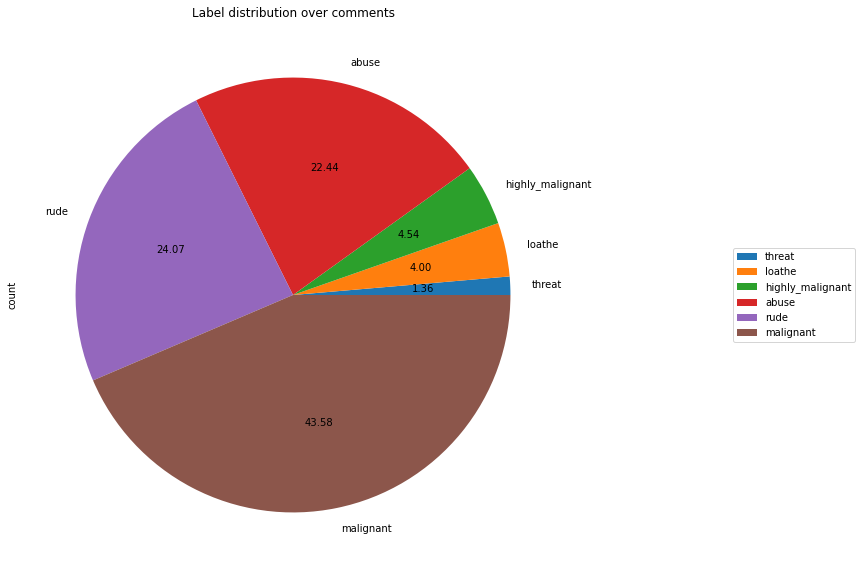

In [26]:
# Visualizing the label distribution of comments using pie chart

comments_labels = ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']
df_distribution = df_train[comments_labels].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.plot.pie(y = 'count', title = 'Label distribution over comments', autopct='%.2f', figsize = (15, 10))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))


#### CORRELATION

In [27]:
df_train.corr

<bound method DataFrame.corr of                       id                                       comment_text  \
0       0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1       000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2       000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3       0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4       0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   
...                  ...                                                ...   
159566  ffe987279560d7ff  ":::::And for the second time of asking, when ...   
159567  ffea4adeee384e90  You should be ashamed of yourself \n\nThat is ...   
159568  ffee36eab5c267c9  Spitzer \n\nUmm, theres no actual article for ...   
159569  fff125370e4aaaf3  And it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nAnd ... I really don't think you understand...   

        malignant  

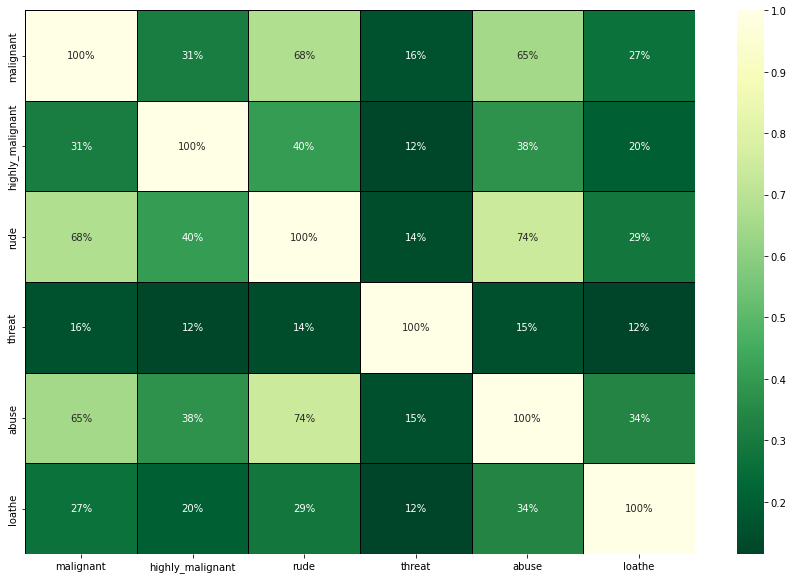

In [28]:
#plotting heatmap for visualizing the correlation

plt.figure(figsize=(15, 10))
corr = df_train.corr() # corr() function provides the correlation value of each column
sns.heatmap(corr, linewidth=0.5, linecolor='black', fmt='.0%', cmap='YlGn_r', annot=True)
plt.show()

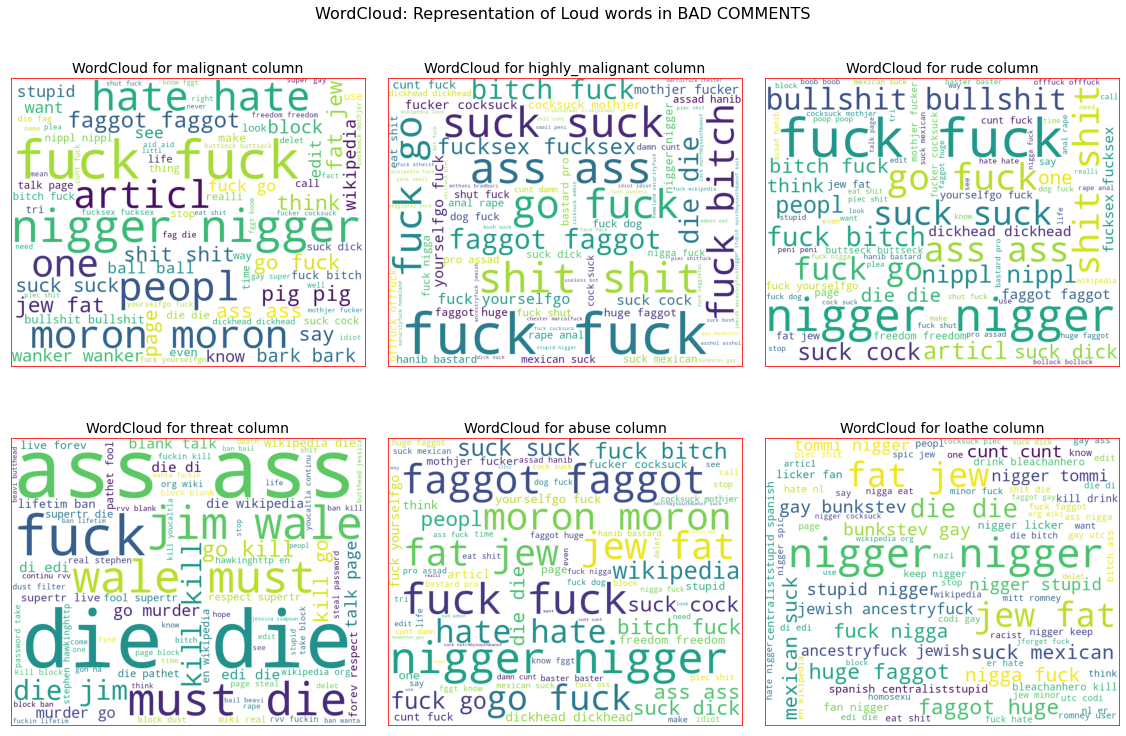

In [29]:
# WordCloud: getting sense of loud words in each of the output labels.

cols = 3
rows = len(output_labels)//cols
if len(output_labels) % cols != 0:
    rows += 1
    
fig = plt.figure(figsize=(16,rows*cols*1.8))
fig.subplots_adjust(top=0.8, hspace=0.3)

p=1
for i in output_labels:
    word_cloud = WordCloud(height=650, width=800,
                           background_color="white",max_words=80).generate(' '.join(df.comment_text[df[i]==1]))
    ax = fig.add_subplot(rows,cols,p)
    ax.imshow(word_cloud)
    ax.set_title(f"WordCloud for {i} column",fontsize=14)
    for spine in ax.spines.values():
        spine.set_edgecolor('r')
       
    ax.set_xticks([])
    ax.set_yticks([])
    p += 1

fig.suptitle("WordCloud: Representation of Loud words in BAD COMMENTS",fontsize=16)
fig.tight_layout(pad=2)
plt.show()

It is observed from above
From wordcloud of malignant comments, it is clear that it mostly consists of words like fuck, nigger, moron, hate, suck ect.

From wordcloud of highly_malignant comments, it is clear that it mostly consists of words like ass, fuck, bitch, shit, die, suck, faggot ect.

From wordcloud of rude comments, it is clear that it mostly consists of words like nigger, ass, fuck, suck, bullshit, bitch etc.

From wordcloud of threat comments, it is clear that it mostly consists of words like die, must die, kill, murder etc.

From wordcloud of abuse comments, it is clear that it mostly consists of words like moron, nigger, fat, jew, bitch etc.

From wordcloud of loathe comments, it is clear that it mostly consists of words like nigga, stupid, nigger, die, gay cunt etc.

### DATA PREPARATION FOR MODEL TRAINING AND TESTING

In [30]:
# 1.Convert text to Vectors

# Converting text to vectors using TfidfVectorizer
tfidf = TfidfVectorizer(max_features=4000)
features = tfidf.fit_transform(df.comment_text).toarray()

# Checking the shape of features
features.shape

(159571, 4000)

In [31]:
# 2. Seperating Input and Output Variables

# input variables
X = features

# output variables
Y = csr_matrix(df[output_labels]).toarray()

# checking shapes of input and output variables to take care of data imbalance issue
print("Input Variable Shape:", X.shape)
print("Output Variable Shape:", Y.shape)

Input Variable Shape: (159571, 4000)
Output Variable Shape: (159571, 6)


## MACHINE LEARNING/MODEL BUILDING

In [33]:
#Training and Testing Model on our train dataset

# Creating a function to train and test model
def build_models(models,x,y,test_size=0.33,random_state=42):
    # spliting train test data using train_test_split
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=test_size,random_state=random_state)
    
    # training models using BinaryRelevance of problem transform
    for i in tqdm.tqdm(models,desc="Building Models"):
        start_time = timeit.default_timer()
        
        sys.stdout.write("\n=======================================================================================\n")
        sys.stdout.write(f"Current Model in Progress: {i} ")
        sys.stdout.write("\n=======================================================================================\n")
        
        br_clf = BinaryRelevance(classifier=models[i]["name"],require_dense=[True,True])
        print("Training: ",br_clf)
        br_clf.fit(x_train,y_train)
        
        print("Testing: ")
        predict_y = br_clf.predict(x_test)
        
        ham_loss = hamming_loss(y_test,predict_y)
        sys.stdout.write(f"\n\tHamming Loss  : {ham_loss}")
                
        ac_score = accuracy_score(y_test,predict_y)
        sys.stdout.write(f"\n\tAccuracy Score: {ac_score}")
        
        cl_report = classification_report(y_test,predict_y)
        sys.stdout.write(f"\n{cl_report}")
        
        end_time = timeit.default_timer()
        sys.stdout.write(f"Completed in [{end_time-start_time} sec.]")
        
        models[i]["trained"] = br_clf
        models[i]["hamming_loss"] = ham_loss
        models[i]["accuracy_score"] = ac_score
        models[i]["classification_report"] = cl_report
        models[i]["predict_y"] = predict_y
        models[i]["time_taken"] = end_time - start_time
                      
        sys.stdout.write("\n=======================================================================================\n")
    
    models["x_train"] = x_train
    models["y_train"] = y_train
    models["x_test"] = x_test
    models["y_test"] = y_test
    
    return models

In [35]:
# Preparing the list of models for classification purpose
models = {"GaussianNB": {"name": GaussianNB()},
          "MultinomialNB": {"name": MultinomialNB()},
          "Logistic Regression": {"name": LogisticRegression()},
          "Random Forest Classifier": {"name": RandomForestClassifier()},
          "Support Vector Classifier": {"name": LinearSVC(max_iter = 3000)},
          "Ada Boost Classifier": {"name": AdaBoostClassifier()},
          "K Nearest Neighbors Classifier": {"name": KNeighborsClassifier()},
          "Decision Tree Classifier": {"name": DecisionTreeClassifier()},
          "Bagging Classifier": {"name": BaggingClassifier(base_estimator=LinearSVC())},
         }

# Taking one forth of the total data for training and testing purpose
half = len(df)//4
trained_models = build_models(models,X[:half,:],Y[:half,:])

Building Models:   0%|          | 0/9 [00:00<?, ?it/s]


Current Model in Progress: GaussianNB 
Training:  BinaryRelevance(classifier=GaussianNB(), require_dense=[True, True])
Testing: 

	Hamming Loss  : 0.21560957083175086
	Accuracy Score: 0.4729965818458033
              precision    recall  f1-score   support

           0       0.16      0.79      0.26      1281
           1       0.08      0.46      0.13       150
           2       0.11      0.71      0.19       724
           3       0.02      0.25      0.03        44
           4       0.10      0.65      0.17       650
           5       0.04      0.46      0.07       109

   micro avg       0.11      0.70      0.20      2958
   macro avg       0.08      0.55      0.14      2958
weighted avg       0.12      0.70      0.21      2958
 samples avg       0.05      0.07      0.05      2958
Completed in [21.931156199999805 sec.]

Current Model in Progress: MultinomialNB 
Training:  BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])
Testing: 

	Hamming Loss  : 0.02409

###### Observation
From the above model comparision it is clear that Linear Support Vector Classifier performs better with Accuracy Score: 91.3558678% and Hamming Loss: 1.9977% than the other classification models. Therefore I am now going to use Linear Support Vector Classifier for further Hyperparameter tuning process.

## HYPERPARAMETER TUNING

In [36]:
# Choosing Linear Support Vector Classifier model

fmod_param = {'estimator__penalty' : ['l1', 'l2'],
              'estimator__loss' : ['hinge', 'squared_hinge'],
              'estimator__multi_class' : ['ovr', 'crammer_singer'],
              'estimator__random_state' : [42, 72, 111]
             }
SVC = OneVsRestClassifier(LinearSVC())
GSCV = GridSearchCV(SVC, fmod_param, cv=3)
x_train,x_test,y_train,y_test = train_test_split(X[:half,:], Y[:half,:], test_size=0.30, random_state=42)
GSCV.fit(x_train,y_train)
GSCV.best_params_

{'estimator__loss': 'hinge',
 'estimator__multi_class': 'ovr',
 'estimator__penalty': 'l2',
 'estimator__random_state': 42}

###### Observation
After comparing all the classification models I have selected Linear Support Vector Classifier as my best model and have listed down it's parameters above referring the sklearn webpage. I am using the Grid Search CV method for hyper parameter tuning my best model. I have trained the Grid Search CV with the list of parameters I feel it should check for best possible outcomes. So the Grid Search CV has provided me with the best parameters list out of all the combinations it used to train the model that I can use on my final model.

#### FINAL MODEL

In [37]:

Final_Model = OneVsRestClassifier(LinearSVC(loss='hinge', multi_class='ovr', penalty='l2', random_state=42))
Classifier = Final_Model.fit(x_train, y_train)
fmod_pred = Final_Model.predict(x_test)
fmod_acc = (accuracy_score(y_test, fmod_pred))*100
print("Accuracy score for the Best Model is:", fmod_acc)
h_loss = hamming_loss(y_test,fmod_pred)*100
print("Hamming loss for the Best Model is:", h_loss)

Accuracy score for the Best Model is: 91.51069518716578
Hamming loss for the Best Model is: 1.9593917112299464


### AUC ROC CURVE

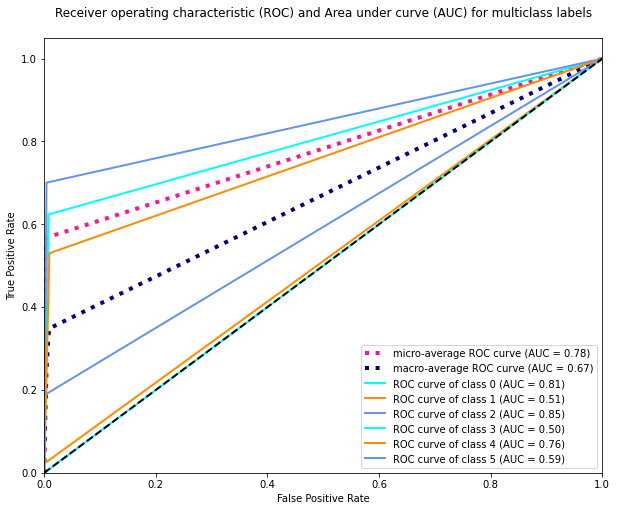

In [38]:
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], fmod_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), fmod_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.rcParams["figure.figsize"] = (10,8) # used to change the output figure size

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (AUC = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC) and Area under curve (AUC) for multiclass labels\n")
plt.legend(loc="lower right")
plt.show()

ROC Curve is generated for our final model and it shows separate curve for every class present in our multi label target variable along with it's AUC values.

### CONFUSION MATRIX

In [39]:
print("Confusion matrix:\n\n", multilabel_confusion_matrix(y_test, fmod_pred))


Confusion matrix:

 [[[10710    83]
  [  442   733]]

 [[11832     1]
  [  132     3]]

 [[11263    47]
  [  197   461]]

 [[11930     0]
  [   38     0]]

 [[11266   106]
  [  280   316]]

 [[11869     3]
  [   78    18]]]


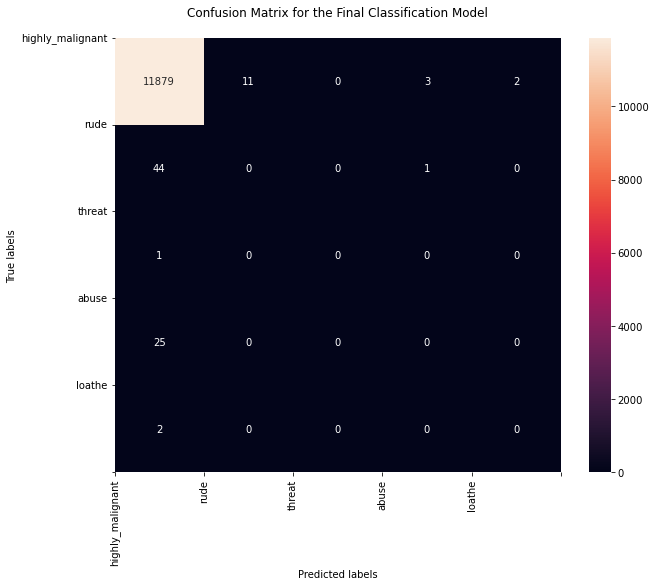

In [40]:
plt.rcParams["figure.figsize"] = (10,8) # used to change the output figure size
ax= plt.subplot()
cm = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(fmod_pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  # annot=True to annotate cells, ftm='g' to disable scientific notation

# title, labels and ticks
ax.set_title('Confusion Matrix for the Final Classification Model\n'); 
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); 
loc = plticker.MultipleLocator()
ax.xaxis.set_major_locator(loc); ax.yaxis.set_major_locator(loc);
ax.set_xticklabels(comments_labels); ax.set_yticklabels(comments_labels);
plt.xticks(rotation=90); plt.yticks(rotation=0);
plt.show()

### SAVING BEST MODEL

In [41]:
# selecting the best model
best_model = trained_models['Support Vector Classifier']['trained']

# saving the best classification model using the joblib option 
joblib.dump(best_model,open('Malignant_comments_classifier.pkl','wb'))

## PREPROCESSING FOR TEST DATASET

The following preprocessing pipeline is required to perform model prediction:

Use the test dataset

Remove null values if any

Drop column id

Convert comment text to lower case and replace '\n' with single space

Keep only text data ie. a-z' and remove other data from comment text

Remove stop words and punctuations

Apply Stemming using SnowballStemmer

Convert text to vectors using TfidfVectorizer

Load saved or serialized best model

Predict values and create a new CSV file

In [42]:
# Remove null values
if df_test.isnull().sum()[1] != 0:
    df_test.dropna(inplace=True)
    
# Drop coulmn id
df_test.drop(columns=['id'],inplace=True)

# Convert comment text to lower case and replace '\n' with single space
df_test["comment_text"] = df_test.comment_text.str.lower()
df_test["comment_text"] = df_test.comment_text.str.replace('\n',' ')

# Keep only text data i.e., a-z' and remove other data from comment text.
df_test.comment_text = df_test.comment_text.apply(lambda x: ' '.join(regexp_tokenize(x,"[a-z']+")))

# Remove stopwords
df_test.comment_text = df_test.comment_text.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words).strip())

# Remove punctuations
df_test.comment_text = df_test.comment_text.str.replace("[^\w\d\s]","")

# Apply Stemming using SnowballStemmer
df_test.comment_text = df_test.comment_text.apply(lambda x: ' '.join(snb_stem.stem(word) for word in word_tokenize(x)))

print(df_test.info(memory_usage="deep"))

# Convert text to vectors using TfidfVectorizer
tfidf = TfidfVectorizer(analyzer = 'word', max_features=4000)
test_features = tfidf.fit_transform(df_test.comment_text).toarray()

# Load saved or serialized model and predict
model_loaded = joblib.load('Malignant_comments_classifier.pkl')

# Make predictions and view the results
predict_test = model_loaded.predict(test_features)

# Saving predicted values into a CSV file
pd.DataFrame(predict_test.toarray()).to_csv('Predicted_test_output.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  153164 non-null  object
dtypes: object(1)
memory usage: 37.2 MB
None


In [43]:
df1 = pd.read_csv('Predicted_test_output.csv')
df1.drop("Unnamed: 0", axis=1, inplace=True)
df1.rename({'0':'malignant', '1':'highly_malignant', '2':'rude', '3':'threat', '4':'abuse', '5':'loathe'}, 
           axis='columns', inplace=True)
df2=df_test.copy()
df = pd.concat([df2, df1], axis=1)
df

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,yo bitch ja rule succes ever what hate sad mof...,0,0,0,0,0,0
1,rfc titl fine imo,0,0,0,0,0,0
2,sourc zaw ashton lapland,0,0,0,0,0,0
3,look back sourc inform updat correct form gues...,0,0,0,0,0,0
4,anonym edit articl,0,0,0,0,0,0
...,...,...,...,...,...,...,...
153159,total agre stuff noth long crap,0,0,0,0,0,0
153160,throw field home plate get faster throw cut ma...,0,0,0,0,0,0
153161,okinotorishima categori see chang agre correct...,0,0,0,0,0,0
153162,one found nation eu germani law return quit si...,0,0,0,0,0,0


In [44]:
df.to_csv('Malignant_Comments_Classifier_test_dataset_predictions.csv', index=False)


## INFERENCE

Starting with univariate analysis, with the help of count plot it was found that dataset is imbalanced with having higher number of records for normal comments than bad comments (including malignant, highly malignant, rude, threat, abuse and loathe). Also, with the help of distribution plot for comments length it was found that after cleaning most of comments length decreases from range 0-1100 to 0-900. Moving further with wordcloud it was found that malignant comments consists of words like fuck, nigger, moron, hate, suck etc. highly_malignant comments consists of words like ass, fuck, bitch, shit, die, suck, faggot etc. rude comments consists of words like nigger, ass, fuck, suck, bullshit, bitch etc. threat comments consists of words like die, must die, kill, murder etc. abuse comments consists of words like moron, nigger, fat, jew, bitch etc. and loathe comments consists of words like nigga, stupid, nigger, die, gay, cunt etc.

..........................................................................................................THANK YOU..............................................................................................